## NOTEBOOK 4: Flight Delay Prediction - Models & Algorithms Implementation

## 1. Import Libraries

In [0]:
import numpy as np
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, max
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType,BooleanType,DateType,StructType
from pyspark.sql.functions import col,udf
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import RobustScaler,StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier,GBTClassifier

##2. Load Dataset

After features engineering, a big table was created and stored in parquet format ready to be used for model and algorithms implementation.

In [0]:
#df = spark.read.parquet("/mnt/mids-w261/Team05_JOINED_FULL_Parquet")
blob_container = "w261group5container" # The name of your container created in https://portal.azure.com
storage_account = "w261team5storage" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261_group_05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261_group_05_key" # The name of the secret key created in your local computer using the Databricks CLI
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"
spark.conf.set(f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",dbutils.secrets.get(scope = secret_scope, key = secret_key))
df = spark.read.format('parquet').option("inferSchema", "true").load(f"{blob_url}/Team05_JOINED_FULL_Parquet")

In [0]:
# Cast month and day_of_week as string
df = df.withColumn("month",col("month").cast(StringType())) \
                 .withColumn("day_of_week",col("day_of_week").cast(StringType()))

##3. Data split techniques

We adopted data from 2016 to 2018 for our model. 2016 was used for training, 2017 was used for validation and 2018 was used for test

In [0]:
#Split into train valid and test sets
DF_train = df.filter((df['year'] == 2016))
DF_valid = df.filter((df['year'] == 2017))
DF_test = df.filter((df['year'] == 2018))

##4. Model pipeline

We built model pipeline using ```spark```. After feature selection, we apply ```FeatureHasher trick``` to map features to indices in the feature vector. ```Numerical and categorical``` attributes are preprocessed and features are extracted, transformed and scaled in the pipeline before feeding it into our model.

**Some the of preprocess steps includes:**

**```StringIndexer```** which  encodes a string or categorical columns of label to  to a column of label indices. The output is fed into ```oneHotEncoder```.

**```OneHotEncoder```** maps a column of label indices to a column of binary vectors.

**```VectorAssembler```** transforms and combines a given list of columns into a single vector column.

**```StandardScaler```** transforms a dataset of vector rows, normalizing each feature to have unit standard deviation and/or zero mean. Two parameters are:

```withStd:``` True by default. Scales the data to unit standard deviation.
```withMean:``` False by default. Centers the data with mean before scaling. It will build a dense output, so take care when applying to sparse input.

**```RobustScaler```** is an estimator which can be fit on a dataset to produce a RobustScalerModel; this amounts to computing quantile statistics. The model can then transform a Vector column in a dataset to have unit quantile range and/or zero median features. Its behavior is quite similar to StandardScaler, however the median and the quantile range are used instead of mean and standard deviation, which make it robust to outliers

##5. Model

###5.1 Baseline Model 
Logistic regression base model was used. No hyper parameter tuning was done at this point.

In [0]:
# Identify and separate categorical variables and numerical variable 

catVariables = ['month','day_of_week','sch_dep_hour_UTC','CASCADE_DELAY','distance_group','op_unique_carrier','origin_airport_id','first_WND_wind_obs_origin','first_WND_wind_obs_dest', 
               'first_VIS_var_origin','first_VIS_var_dest','first_CIG_ceil_vis_origin','first_CIG_ceil_vis_dest']

numVariables = ["avg_dep_delay_origin","avg_dep_delay_dest", "pct_dep_delayed_origin", "pct_dep_delayed_dest","avg_weather_delay_origin","avg_weather_delay_dest","avg_nas_delay_origin",
                "avg_nas_delay_dest",'WND_dir_angle_avg_origin','WND_dir_angle_avg_dest',"avg_sec_delay_origin","avg_sec_delay_dest","flight_count_carrier","avg_dep_delay_carrier",
                "avg_carrier_delay_carrier","WND_speed_avg_origin","WND_speed_avg_dest","CIG_avg_ceil_ht_origin","CIG_avg_ceil_ht_dest","avg_TMP_air_temp_origin","avg_TMP_air_temp_dest"]

# Pipeline stages are run in this order
stages=[]

#Split data into training and validation set
df_features = catVariables+numVariables+['dep_del15'] # Concatenate all features with our predictor variable

#Final train and test sets
trainRdd_base = DF_train.select(df_features)
validRdd_base = DF_valid.select(df_features)
 
for column in catVariables:
  #StringIndex categorical
  column_index = StringIndexer(inputCol=column, outputCol= column+'Index').setHandleInvalid("keep")
  
  #Receives ouput from column_index and One-hot_encodes
  one_hot_encoder = OneHotEncoder(inputCols=[column_index.getOutputCol()],outputCols=[column+'HotEncoded'])
  stages += [column_index, one_hot_encoder]
  
#Preprocess our label
dep_del15_index = StringIndexer(inputCol = 'dep_del15', outputCol = 'label')
stages += [dep_del15_index]

#A feature transformer that merges multiple columns into a vector column.
num_assembler = VectorAssembler(inputCols=numVariables,outputCol="assembler_vec").setHandleInvalid("skip")

#Scales the numerical variables. We'll consider RobustStandardScaler with standardScaler to see which performs better.
scaler = StandardScaler(inputCol="assembler_vec", outputCol="scaled_assembler_vec")
stages += [num_assembler,scaler]
 
#Feature assembler
feature_assembler = [column + "HotEncoded" for column in catVariables] + ['scaled_assembler_vec']
assembler = VectorAssembler(inputCols=feature_assembler, outputCol="features")
stages += [assembler]

# We now have all pipeline stages.
pipeline = Pipeline(stages = stages)

# Fit and transform train and validation set
model_pipeline_base = pipeline.fit(trainRdd_base)
rdd_train_base = model_pipeline_base.transform(trainRdd_base).select(['label', 'features'] + df_features)
rdd_valid_base = model_pipeline_base.transform(validRdd_base).select(['label', 'features'] + df_features)

In [0]:
# We keeping our base model simple: No hyperparameter tunning yet.
logis_base = LogisticRegression()
base_model = logis_base.fit(rdd_train_base)
base_predictions = base_model.transform(rdd_valid_base)

###5.1.1 Evaluation Metrics

We defined a function that evaluates returns metrics

In [0]:
def evaluate(predictionAndLabels):
  """ Returns metrics for each classes and overall performance of the model"""
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    
    print(" ")

    # Confusion Matrix
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    confusion_matrix = metrics.confusionMatrix().toArray()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    
    
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    accuracy = evaluator.evaluate(predictionAndLabels)
    print("Test Error = %g" % (1.0 - accuracy))
    print(" ")
    # Overall statistics
    log["Accuracy"] = "%s" % metrics.accuracy
    log['precision'] = "%s" % metrics.precision(1)
    log['recall'] = "%s" % metrics.recall(label=1)
    log['F1 Measure'] = "%s" % metrics.fMeasure(1.0,1.0)
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s | Accuracy = %s" % \
            (log['precision'], log['recall'], log['F1 Measure'],log['Accuracy']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]["Accuracy"] = "%s" % metrics.accuracy
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label,beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s |Accuracy = %s" \
                  % (label, log[label]['precision'],log[label]['recall'], log[label]['F1 Measure'],log[label]['Accuracy']))

    return log

Area under ROC = 0.760161
Area under PR = 0.526413
 
Test Error = 0.143672
 
[Overall]	precision = 0.6707706159069151 | recall = 0.3813124822596759 | F1 Measure = 0.4862224457821625 | Accuracy = 0.8346885904172462
[Class 0.0]	precision = 0.8563275214015901 | recall = 0.9516977932365144 | F1 Measure = 0.9014973471969459 |Accuracy = 0.8346885904172462
[Class 1.0]	precision = 0.6707706159069151 | recall = 0.3813124822596759 | F1 Measure = 0.4862224457821625 |Accuracy = 0.8346885904172462

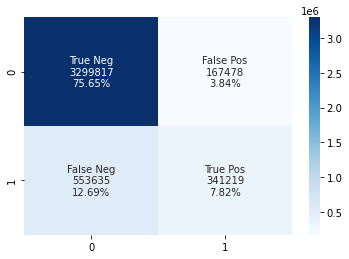

In [0]:
log = evaluate(base_predictions)

#### Base Model Result Analysis 
Though the baseline accuracy is impressive at ```83.5%```, precision showed a considerable average strength in performance. Unfortunately, recall is ```38.1%```. Also observed is the performnace of class ```0``` . It showed SOTA performance. However,class ```1``` results are very low. The is likely due imbalanced dataset where about about 80% of cases are negative thereby assigning negative to majority cases, which led the model to bias towards class ```0``` resulting in precision and low recall for the positive cases. We will verify this next before moving on to the next model.

In [0]:
#Check for imblanced dataset using the training set
df_sns = DF_train.select(["dep_del15"]).toPandas()

label_sum = df_sns.sum()
label_count = df_sns.groupby("dep_del15")["dep_del15"].count()
df_count= pd.DataFrame(label_count)
df_count

Out[85]:

,dep_del15
dep_del15,
0.0,3499458
1.0,842791


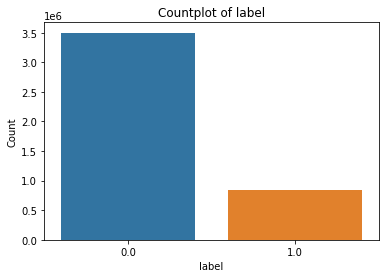

In [0]:
#Plotting the distribution 
df_sns = DF_train.select(["dep_del15"]).toPandas()
sns.countplot(df_sns["dep_del15"])

# Add labels
plt.title('Countplot of label')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

The plot shows  a disproportionate ratio of observations in each class confirming the imbalance dataset. Without further transformations, the model would result in bias towards ```0``` prediction favoring ```Not delayed```. We explored many ways to treat this imbalanced dataset to strengthen precision and recall.

In this study we have introduced a rebalancing strength ```alpha``` to down sample the negative class in order to boost the recall.

**Some of many possible options to deal with imbalanced datasets**
_Change the performance metric_

_Change the algorithm type_

_Oversample minority class_

_Undersample majority class_

_Generate synthetic samples_

We **undersampled majority class** as we have enough data instead of generating a synthetic data that would further the scale of the dataset

## Rebalancing dataset

In [0]:
# Beacause the label is over represented, we will undersample the majority class
DF_count0 =DF_train.filter(col('dep_del15') ==0)
DF_count1 =DF_train.filter(col('dep_del15') ==1)

count_df = int(DF_count0.count()/DF_count1.count())
# Using alpha strength of 0.69, we created a new train set with rebalanced data
DF_count0_new = DF_count0.sample(False, 0.69/count_df, seed=101)
DF_train_new = DF_count1.union(DF_count0_new)


display(DF_train_new.groupby('dep_del15').count())

dep_del15,count
1.0,842791
0.0,603815


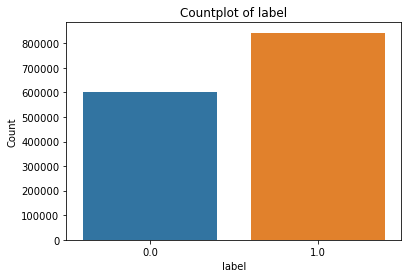

In [0]:
#Plotting the distribution 
df_sns = DF_train_new.select(["dep_del15"]).toPandas()
sns.countplot(df_sns["dep_del15"])

# Add labels
plt.title('Countplot of label')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [0]:
#USING NEW TRAIN SET WITH REBALANCED DATASET
catVariables = ['month','day_of_week','sch_dep_hour_UTC','CASCADE_DELAY','distance_group','op_unique_carrier','origin_airport_id','first_WND_wind_obs_origin','first_WND_wind_obs_dest', 
               'first_VIS_var_origin','first_VIS_var_dest','first_CIG_ceil_vis_origin','first_CIG_ceil_vis_dest']

numVariables = ["avg_dep_delay_origin","avg_dep_delay_dest", "pct_dep_delayed_origin", "pct_dep_delayed_dest","avg_weather_delay_origin","avg_weather_delay_dest","avg_nas_delay_origin",
                "avg_nas_delay_dest",'WND_dir_angle_avg_origin','WND_dir_angle_avg_dest',"avg_sec_delay_origin","avg_sec_delay_dest","flight_count_carrier","avg_dep_delay_carrier",
                "avg_carrier_delay_carrier","WND_speed_avg_origin","WND_speed_avg_dest","CIG_avg_ceil_ht_origin","CIG_avg_ceil_ht_dest","avg_TMP_air_temp_origin","avg_TMP_air_temp_dest"]

# Pipeline stages are run in this order
stages=[]

#Split data into training and validation set
df_features = catVariables+numVariables+['dep_del15'] # Concatenate all features with our predictor variable

#Final train and test sets
trainRdd = DF_train_new.select(df_features) #New train data with rebalanced data
validRdd = DF_valid.select(df_features)
 
for column in catVariables:
  #StringIndex categorical
  column_index = StringIndexer(inputCol=column, outputCol= column+'Index').setHandleInvalid("keep")
  
  #Receives ouputfrom column_index and One-hot_encodes
  one_hot_encoder = OneHotEncoder(inputCols=[column_index.getOutputCol()],outputCols=[column+'HotEncoded'])
  stages += [column_index, one_hot_encoder]
  
#Preprocess our label
dep_del15_index = StringIndexer(inputCol = 'dep_del15', outputCol = 'label')
stages += [dep_del15_index]

#A feature transformer that merges multiple columns into a vector column.
num_assembler = VectorAssembler(inputCols=numVariables,outputCol="assembler_vec").setHandleInvalid("skip")

#Scales the numerical variables. We'll consider RobustStandardScaler with standardScaler to see which performs better.
scaler = StandardScaler(inputCol="assembler_vec", outputCol="scaled_assembler_vec")
stages += [num_assembler,scaler]
 
#Feature assembler
feature_assembler = [column + "HotEncoded" for column in catVariables] + ['scaled_assembler_vec']
assembler = VectorAssembler(inputCols=feature_assembler, outputCol="features")
stages += [assembler]

# We now have all pipeline stages.
pipeline = Pipeline(stages = stages)

# Fit into our training set
model_pipeline = pipeline.fit(trainRdd)
 
# Final pipeline transformation
rdd_train = model_pipeline.transform(trainRdd).select(['label', 'features'] + df_features)
rdd_valid = model_pipeline.transform(validRdd).select(['label', 'features'] + df_features)

### 5.1.2 Baseline Model with Rebalanced Dataset

In [0]:
# We keeping our base model simple: No hyperparameter tunning yet.
logis_base_model = LogisticRegression()
base_model_balanced = logis_base_model.fit(rdd_train)
predictions = base_model_balanced.transform(rdd_valid)

Area under ROC = 0.760743
Area under PR = 0.906110
 
Test Error = 0.593951
 
[Overall]	precision = 0.8984891391998374 | recall = 0.6529851079876388 | F1 Measure = 0.756312943833519 | Accuracy = 0.6655320577082534
[Class 0.0]	precision = 0.3468878731080992 | recall = 0.7141477827667977 | F1 Measure = 0.466957362039958 |Accuracy = 0.6655320577082534
[Class 1.0]	precision = 0.8984891391998374 | recall = 0.6529851079876388 | F1 Measure = 0.756312943833519 |Accuracy = 0.6655320577082534

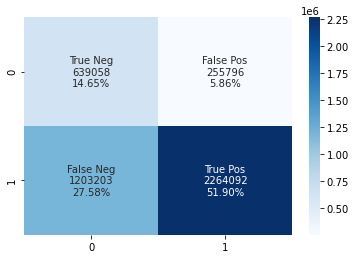

In [0]:
log = evaluate(predictions)

Results with rebalanced dataset show a great improvement on precision and recall. Hence, the model of the model will de trained using the rebalanced dataset

##5.2 Production Model

###5.2.1 Logistic Regression

We further improve the baseline logistic regression by building a parameter grid and tunning hyperparameters.

In [0]:
lr = LogisticRegression()
lr_model = lr.fit(rdd_train)
lr_predictions = lr_model.transform(rdd_valid)

In [0]:
lr_paramGrid = ParamGridBuilder()\
    .addGrid(lr_model.aggregationDepth,[2,5,10,15])\
    .addGrid(lr_model.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr_model.maxIter,[10,20,25])\
    .addGrid(lr_model.regParam,[0.01, 0.1, 1.5]) \
    .build()

evaluator=MulticlassClassificationEvaluator(metricName="precisionByLabel")

#Create 3-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator)

# Run cross validations
cv_model = cv.fit(rdd_train)

# Takes fair amount of time
predict_train=cv_model.transform(rdd_train)
predict_valid=cv_model.transform(rdd_valid)

# Checking train and validation set ROC
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_valid)))

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
The area under ROC for train set after CV is 0.7731503397017229
The area under ROC for test set after CV is 0.386106735432881

Area under ROC = 0.695387
Area under PR = 0.867498
 
Test Error = 0.593951
 
[Overall]	precision = 0.8704727309130693 | recall = 0.7723963493155327 | F1 Measure = 0.8185070467604401 | Accuracy = 0.727731216884155
[Class 0.0]	precision = 0.386106735432881 | recall = 0.554667018306897 | F1 Measure = 0.4552862382468289 |Accuracy = 0.727731216884155
[Class 1.0]	precision = 0.8704727309130693 | recall = 0.7723963493155327 | F1 Measure = 0.8185070467604401 |Accuracy = 0.727731216884155

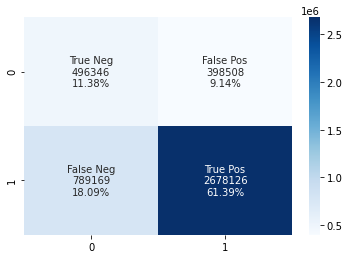

In [0]:
log = evaluate(predict_valid)

This enhanced logistic regession model performed better than the base model with rebalanced dataset. The trade-off between precision and recall was greatly improved.

###5.2.2 Support Vector Machine

In [0]:
svc = LinearSVC()
svc_model = svc.fit(rdd_train)
svc_predictions = svc_model.transform(rdd_valid)

In [0]:
svc_paramGrid = ParamGridBuilder() \
  .addGrid(svc.maxIter, [10,15]) \
  .addGrid(svc.regParam,[0.01, 0.1, 1.0]) \
  .build()
  
#svc_evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR')
svc_evaluator = evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")

#Create 3-fold CrossValidator. We will increase this during the final training
svc_cv = CrossValidator(estimator=svc, estimatorParamMaps=svc_paramGrid, evaluator=svc_evaluator, numFolds=3)

# Run cross validations
svc_cv_model = svc_cv.fit(rdd_train)

# This will take a fair amount of time
svc_predict_train=svc_cv_model.transform(rdd_train)
svc_predict_valid=svc_cv_model.transform(rdd_valid)


print("The area under ROC for train set after CV  is {}".format(svc_evaluator.evaluate(svc_predict_train)))
print("The area under ROC for test set after CV  is {}".format(svc_evaluator.evaluate(svc_predict_valid)))

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
The area under ROC for train set after CV is 0.83047224558213
The area under ROC for test set after CV is 0.4725546855145171

Area under ROC = 0.742412
Area under PR = 0.897333
 
Test Error = 0.593951
 
[Overall]	precision = 0.8743384422133715 | recall = 0.8479647679242752 | F1 Measure = 0.8609496746853076 | Accuracy = 0.7822829985862473
[Class 0.0]	precision = 0.4725546855145171 | recall = 0.5277855381995276 | F1 Measure = 0.4986454070535967 |Accuracy = 0.7822829985862473
[Class 1.0]	precision = 0.8743384422133715 | recall = 0.8479647679242752 | F1 Measure = 0.8609496746853076 |Accuracy = 0.7822829985862473

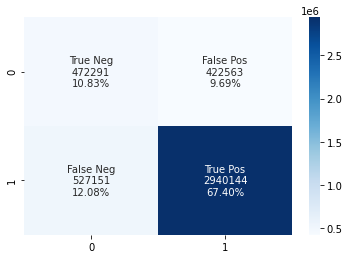

In [0]:
#Evaluate 
log = evaluate(svc_predict_valid)

This performed even better than the logistic regression model. Preciosn-recall showed close results.

###5.2.3 Random Forest

We resigned our pipeline for random forest classifier to remove Standard scaler features since this may affect the performance of the tree model.

In [0]:
catVariables = ['month','day_of_week','sch_dep_hour_UTC','CASCADE_DELAY','distance_group','op_unique_carrier','origin_airport_id','first_WND_wind_obs_origin','first_WND_wind_obs_dest', 
               'first_VIS_var_origin','first_VIS_var_dest','first_CIG_ceil_vis_origin','first_CIG_ceil_vis_dest']

numVariables = ["avg_dep_delay_origin","avg_dep_delay_dest", "pct_dep_delayed_origin", "pct_dep_delayed_dest","avg_weather_delay_origin","avg_weather_delay_dest","avg_nas_delay_origin",
                "avg_nas_delay_dest",'WND_dir_angle_avg_origin','WND_dir_angle_avg_dest',"avg_sec_delay_origin","avg_sec_delay_dest","flight_count_carrier","avg_dep_delay_carrier",
                "avg_carrier_delay_carrier","WND_speed_avg_origin","WND_speed_avg_dest","CIG_avg_ceil_ht_origin","CIG_avg_ceil_ht_dest","avg_TMP_air_temp_origin","avg_TMP_air_temp_dest"]

stages=[]

#Split data into training and validation sets
df_features = catVariables+numVariables+['dep_del15'] # Concatenate all features with our predictor variable

#Final train and test sets
trainRdd = DF_train_new.select(df_features)
validRdd = DF_valid.select(df_features)
 
for column in catVariables:
  #StringIndex categorical
  column_index = StringIndexer(inputCol=column, outputCol= column+'Index').setHandleInvalid("keep")
  
  #Receives ouputfrom column_index and One-hot_encodes
  one_hot_encoder = OneHotEncoder(inputCols=[column_index.getOutputCol()],outputCols=[column+'HotEncoded'])
  stages += [column_index, one_hot_encoder]
  
#Preprocess our label
dep_del15_index = StringIndexer(inputCol = 'dep_del15', outputCol = 'label')
stages += [dep_del15_index]

#A feature transformer that merges multiple columns into a vector column.
num_assembler = VectorAssembler(inputCols=numVariables,outputCol="assembler_vec").setHandleInvalid("skip")

#Scales the numerical variables. We'll consider RobustStandardScaler with standardScaler to see which performs better.
#scaler = StandardScaler(inputCol="assembler_vec", outputCol="scaled_assembler_vec")
#stages += [num_assembler,scaler]
stages += [num_assembler]
 
#Feature assembler
feature_assembler = [column + "HotEncoded" for column in catVariables] + ['assembler_vec']
assembler = VectorAssembler(inputCols=feature_assembler, outputCol="features")
stages += [assembler]

# We now have all pipeline stages.
pipeline = Pipeline(stages = stages)

# Fit into our training set
model_pipeline = pipeline.fit(trainRdd)
 
# Final pipeline transformation
rf_rdd_train = model_pipeline.transform(trainRdd).select(['label', 'features'] + df_features)
rf_rdd_valid = model_pipeline.transform(validRdd).select(['label', 'features'] + df_features)

In [0]:
rf = RandomForestClassifier()
rf_model = rf.fit(rf_rdd_train)
rf_predictions = rf_model.transform(rf_rdd_valid)

In [0]:
rf_paramGrid = ParamGridBuilder() \
  .addGrid(rf.maxBins, [20, 25,31 ,35]) \
  .addGrid(rf.maxDepth, [6, 15,20]) \
  .addGrid(rf.impurity,["entropy", "gini"]) \
  .build()
  
  
#rf_evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_evaluator = evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")

#Create 5-fold CrossValidator
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=rf_evaluator, numFolds=3)

# Run cross validations
rf_cv_model = rf_cv.fit(rf_rdd_train)

# this will likely take a fair amount of time because of the amount of models that we're creating and testing
rf_predict_train=rf_cv_model.transform(rf_rdd_train)
rf_predict_valid=rf_cv_model.transform(rf_rdd_valid)


print("The area under ROC for train set after CV  is {}".format(rf_evaluator.evaluate(rf_predict_train)))
print("The area under ROC for test set after CV  is {}".format(rf_evaluator.evaluate(rf_predict_valid)))

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
The area under ROC for train set after CV is 0.8016182152513828
The area under ROC for test set after CV is 0.3522881581265367

Area under ROC = 0.765519
Area under PR = 0.908523
 
Test Error = 0.593951
 
[Overall]	precision = 0.9009839615490697 | recall = 0.6585554445179888 | F1 Measure = 0.7609270929522287 | Accuracy = 0.6710726754175522
[Class 0.0]	precision = 0.3522881581265367 | recall = 0.719573248820478 | F1 Measure = 0.4730035671050621 |Accuracy = 0.6710726754175522
[Class 1.0]	precision = 0.9009839615490697 | recall = 0.6585554445179888 | F1 Measure = 0.7609270929522287 |Accuracy = 0.6710726754175522

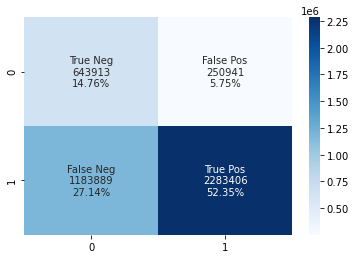

In [0]:
#Evaluate 
log = evaluate(rf_predict_valid)

Random Forest showed a great improvement in precision but did not do so well on recall.

###5.2.4 XGBoost

In [0]:
#Fine tune alpha for XGBoost
DF_count0 =DF_train.filter(col('dep_del15') ==0)
DF_count1 =DF_train.filter(col('dep_del15') ==1)

count_df = int(DF_count0.count()/DF_count1.count())
DF_count0_new = DF_count0.sample(False, 0.78/count_df, seed=101)
DF_train_gbt = DF_count1.union(DF_count0_new)


display(DF_train_new.groupby('dep_del15').count())

dep_del15,count
1.0,842791
0.0,603485


In [0]:

catVariables = ['month','day_of_week','sch_dep_hour_UTC','CASCADE_DELAY','distance_group','op_unique_carrier','origin_airport_id','first_WND_wind_obs_origin','first_WND_wind_obs_dest', 
               'first_VIS_var_origin','first_VIS_var_dest','first_CIG_ceil_vis_origin','first_CIG_ceil_vis_dest']

numVariables = ["avg_dep_delay_origin","avg_dep_delay_dest", "pct_dep_delayed_origin", "pct_dep_delayed_dest","avg_weather_delay_origin","avg_weather_delay_dest","avg_nas_delay_origin",
                "avg_nas_delay_dest",'WND_dir_angle_avg_origin','WND_dir_angle_avg_dest',"avg_sec_delay_origin","avg_sec_delay_dest","flight_count_carrier","avg_dep_delay_carrier",
                "avg_carrier_delay_carrier","WND_speed_avg_origin","WND_speed_avg_dest","CIG_avg_ceil_ht_origin","CIG_avg_ceil_ht_dest","avg_TMP_air_temp_origin","avg_TMP_air_temp_dest"]


# Pipeline stages is either a Transformer or an Estimator. These stages are run in order
stages=[]

#Spliting data into training and test sets
df_features = catVariables+numVariables+['dep_del15'] # Concatenate all features with our predictor variable

#Final train and test sets
trainRdd = DF_train_gbt.select(df_features)
validRdd = DF_valid.select(df_features)
 
for column in catVariables:
  #StringIndex categorical
  column_index = StringIndexer(inputCol=column, outputCol= column+'Index').setHandleInvalid("keep")
  
  #Receives ouputfrom column_index and One-hot_encodes
  one_hot_encoder = OneHotEncoder(inputCols=[column_index.getOutputCol()],outputCols=[column+'HotEncoded'])
  stages += [column_index, one_hot_encoder]
  
#Preprocess our label
dep_del15_index = StringIndexer(inputCol = 'dep_del15', outputCol = 'label')
stages += [dep_del15_index]

#A feature transformer that merges multiple columns into a vector column.
num_assembler = VectorAssembler(inputCols=numVariables,outputCol="assembler_vec").setHandleInvalid("skip")

#Scales the numerical variables. We'll consider RobustStandardScaler with standardScaler to see which performs better.
#scaler = StandardScaler(inputCol="assembler_vec", outputCol="scaled_assembler_vec")
#stages += [num_assembler,scaler]
stages += [num_assembler]
 
#Feature assembler
feature_assembler = [column + "HotEncoded" for column in catVariables] + ['assembler_vec']
assembler = VectorAssembler(inputCols=feature_assembler, outputCol="features")
stages += [assembler]

# We now have all pipeline stages.
pipeline = Pipeline(stages = stages)

# Fit into our training set
model_pipeline = pipeline.fit(trainRdd)
 
# Final pipeline transformation
gbt_rdd_train = model_pipeline.transform(trainRdd).select(['label', 'features'] + df_features)
gbt_rdd_valid = model_pipeline.transform(validRdd).select(['label', 'features'] + df_features)

In [0]:
#Loop and display best tree for the model
num_tree=[6,10,20]
results = []
precision_score=[]
for tree in num_tree:
  gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=tree)
  gbt_model = gbt.fit(gbt_rdd_train)
  gbt_predictions = gbt_model.transform(gbt_rdd_valid)
  predictions = gbt_predictions.select(['prediction', 'label'])
  gbt_metrics = MulticlassMetrics(predictions.rdd)
  
  recal=gbt_metrics.recall(label=1)
  prec= gbt_metrics.precision(1)
  acc= gbt_metrics.accuracy
  F1= gbt_metrics.fMeasure(1.0,1.0)
  results.append([acc,recal,prec,F1])
  precision_score.append(prec)
  print(prec)
  
best_score = np.argmax(precision_score)
print('PR',num_tree[best_score])
print('Accuracy = ',results[best_score][0])
print('Recall = ',results[best_score][1])
print('Precision = ',results[best_score][2])
print('F1 = ',results[best_score][3])

0.882088158027064
0.885522636740946
0.8896368072310545
PR 20
Accuracy = 0.733435973874345
Recall = 0.7587684347596614
Precision = 0.8896368072310545
F1 = 0.8190077421885458

Overall SVM performed really good. Due to the power and strenght of ensemble method and it's robustness to outliers, our final model will use XGBoost with the best k

### 5.2.5 Deployment Model

#### Using XGBoost with 20 number of trees

In [0]:
catVariables = ['month','day_of_week','sch_dep_hour_UTC','CASCADE_DELAY','distance_group','op_unique_carrier','origin_airport_id','first_WND_wind_obs_origin','first_WND_wind_obs_dest', 
               'first_VIS_var_origin','first_VIS_var_dest','first_CIG_ceil_vis_origin','first_CIG_ceil_vis_dest']

numVariables = ["avg_dep_delay_origin","avg_dep_delay_dest", "pct_dep_delayed_origin", "pct_dep_delayed_dest","avg_weather_delay_origin","avg_weather_delay_dest","avg_nas_delay_origin",
                "avg_nas_delay_dest",'WND_dir_angle_avg_origin','WND_dir_angle_avg_dest',"avg_sec_delay_origin","avg_sec_delay_dest","flight_count_carrier","avg_dep_delay_carrier",
                "avg_carrier_delay_carrier","WND_speed_avg_origin","WND_speed_avg_dest","CIG_avg_ceil_ht_origin","CIG_avg_ceil_ht_dest","avg_TMP_air_temp_origin","avg_TMP_air_temp_dest"]


# Pipeline stages is either a Transformer or an Estimator. These stages are run in order
stages=[]

#Spliting data into training and test sets
df_features = catVariables+numVariables+['dep_del15'] # Concatenate all features with our predictor variable

#Final train and test sets
trainRdd = DF_train_gbt.select(df_features)
testRdd = DF_test.select(df_features)
 
for column in catVariables:
  #StringIndex categorical
  column_index = StringIndexer(inputCol=column, outputCol= column+'Index').setHandleInvalid("keep")
  
  #Receives ouputfrom column_index and One-hot_encodes
  one_hot_encoder = OneHotEncoder(inputCols=[column_index.getOutputCol()],outputCols=[column+'HotEncoded'])
  stages += [column_index, one_hot_encoder]
  
#Preprocess our label
dep_del15_index = StringIndexer(inputCol = 'dep_del15', outputCol = 'label')
stages += [dep_del15_index]

#A feature transformer that merges multiple columns into a vector column.
num_assembler = VectorAssembler(inputCols=numVariables,outputCol="assembler_vec").setHandleInvalid("skip")

#Scales the numerical variables. We'll consider RobustStandardScaler with standardScaler to see which performs better.
#scaler = StandardScaler(inputCol="assembler_vec", outputCol="scaled_assembler_vec")
#stages += [num_assembler,scaler]
stages += [num_assembler]
 
#Feature assembler
feature_assembler = [column + "HotEncoded" for column in catVariables] + ['assembler_vec']
assembler = VectorAssembler(inputCols=feature_assembler, outputCol="features")
stages += [assembler]

# We now have all pipeline stages.
pipeline = Pipeline(stages = stages)

# Fit into our training set
model_pipeline = pipeline.fit(trainRdd)
 
# Final pipeline transformation
gbt_rdd_train = model_pipeline.transform(trainRdd).select(['label', 'features'] + df_features)
gbt_rdd_test = model_pipeline.transform(testRdd).select(['label', 'features'] + df_features)

In [0]:
#Generate predictions for entire dataset
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=20 )
gbt_model_final = gbt.fit(gbt_rdd_train)
gbt_predictions_final = gbt_model_final.transform(gbt_rdd_test)

Area under ROC = 0.753583
Area under PR = 0.900780
 
Test Error = 0.595506
 
[Overall]	precision = 0.8851183075287886 | recall = 0.756464317925618 | F1 Measure = 0.8157498823464964 | Accuracy = 0.7295678554603827
[Class 0.0]	precision = 0.40449416632412927 | recall = 0.6275341448202886 | F1 Measure = 0.4919126694645251 |Accuracy = 0.7295678554603827
[Class 1.0]	precision = 0.8851183075287886 | recall = 0.756464317925618 | F1 Measure = 0.8157498823464964 |Accuracy = 0.7295678554603827

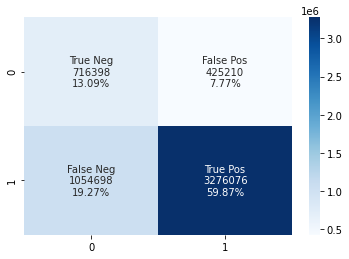

In [0]:
# Predict delay or no delay
log = evaluate(gbt_predictions_final)

##6 Feature Importance

In [0]:
def feature_importance(feature_imp, prediction, feature_col):
    feature_list = []
    for feature in prediction.schema[feature_col].metadata["ml_attr"]["attrs"]:
        feature_list = feature_list + prediction.schema[feature_col].metadata["ml_attr"]["attrs"][feature]
        
    # Store in Dataframe    
    df = pd.DataFrame(feature_list)
    df['feature_score'] = df['idx'].apply(lambda x: feature_imp[x])
    return(df.sort_values('feature_score', ascending = False))

In [0]:
features_importance = feature_importance(gbt_model_final.featureImportances,gbt_predictions_final, "features").head(50)
features_importance

Out[52]:

,idx,name,feature_score
65,44,CASCADE_DELAYHotEncoded_1.0,0.351715
19,369,assembler_vec_avg_TMP_air_temp_origin,0.052608
64,43,CASCADE_DELAYHotEncoded_0.0,0.051458
17,367,assembler_vec_CIG_avg_ceil_ht_origin,0.049351
13,363,assembler_vec_avg_dep_delay_carrier,0.048133
12,362,assembler_vec_flight_count_carrier,0.043463
18,368,assembler_vec_CIG_avg_ceil_ht_dest,0.039151
23,2,monthHotEncoded_6,0.033293
22,1,monthHotEncoded_8,0.026821
16,366,assembler_vec_WND_speed_avg_dest,0.025891


Out[66]:

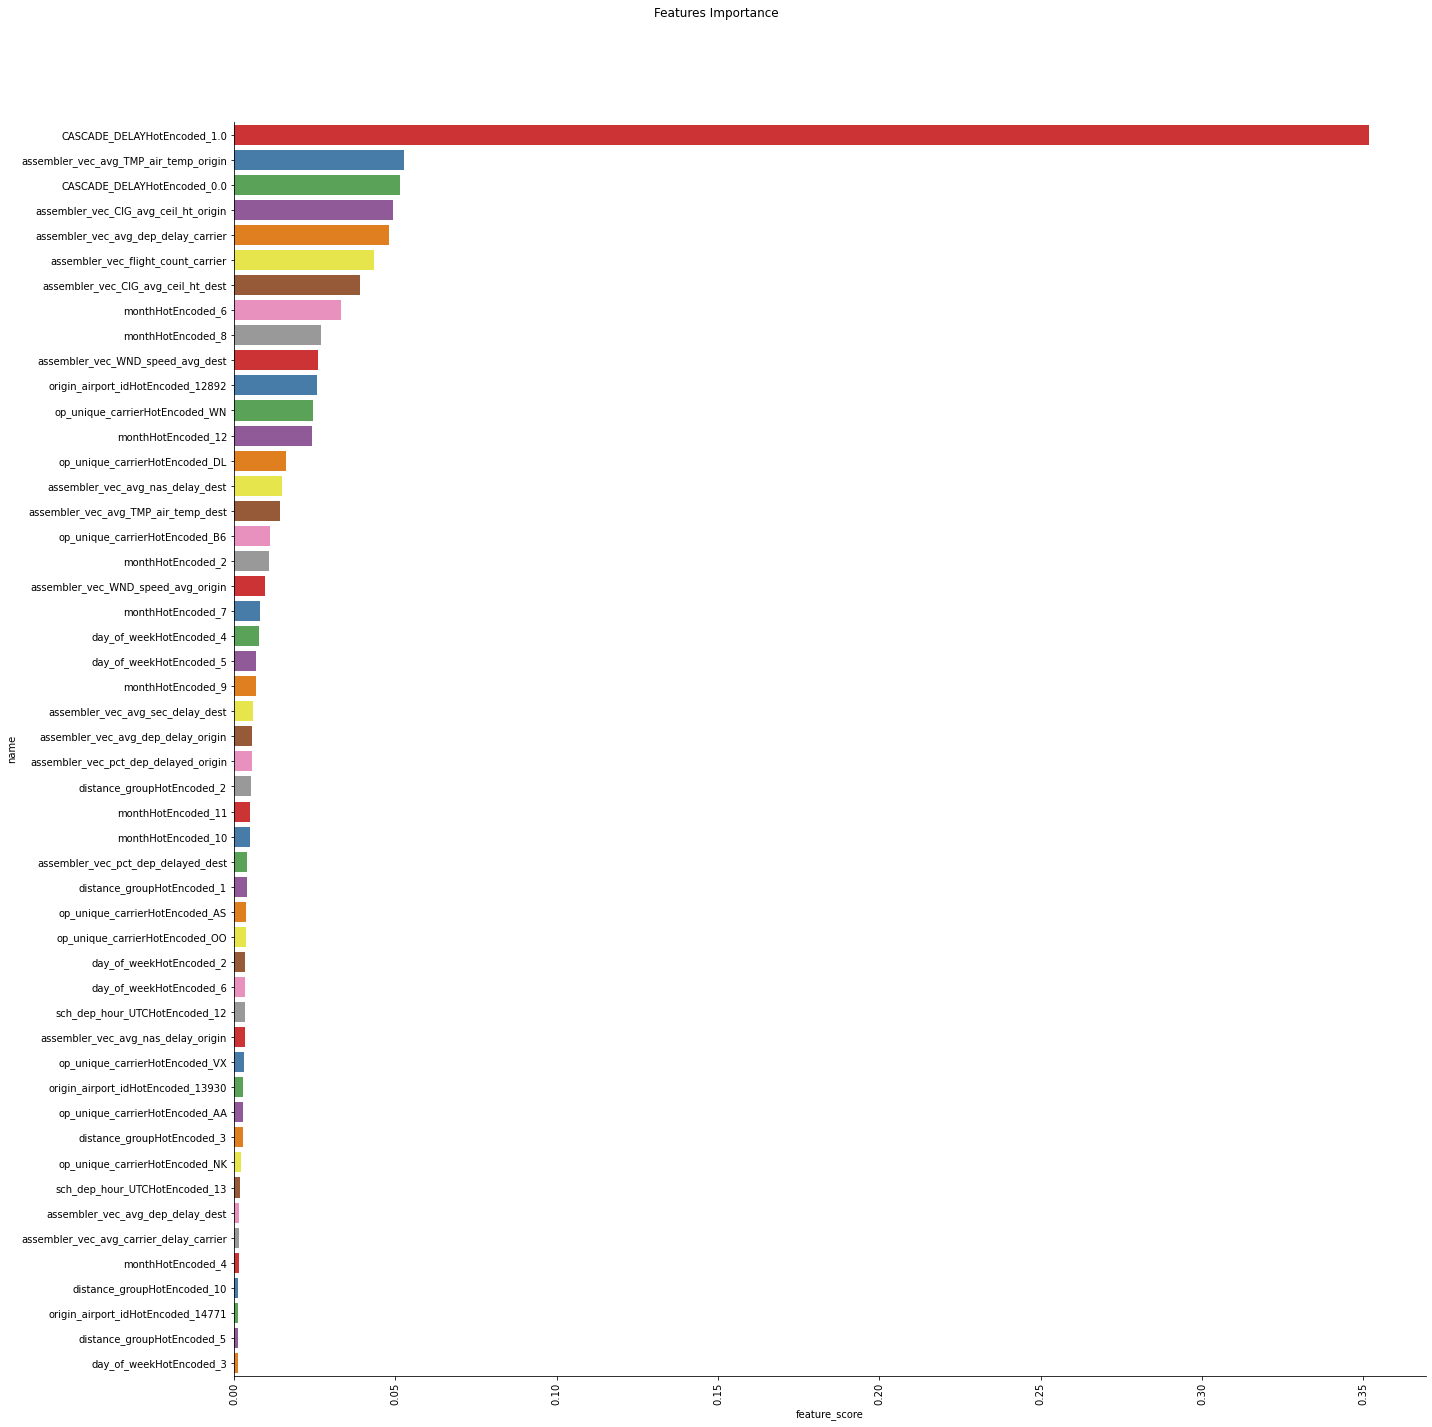

(array([0. , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text major ticklabel objects>)

In [0]:
plt.figure(figsize=(7,20))
ax = sns.catplot(y="name", x="feature_score",kind="bar",data=features_importance, aspect=1,palette='Set1',height=20)
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Features Importance')
plt.xticks(rotation = 'vertical')

The plot above showed feature importance which of one-hot encoded categorical variables and numberical variables features. It is remarkable to see how much important CASCADE delay contributes to the model.